# **Acknowledgements**
To the following whose kernels I used extensively for this kernel:
* Manav Sehgal - "Titanic Data Science Solutions" - https://www.kaggle.com/startupsci/titanic-data-science-solutions/notebook
* Pedro Marcelino - "Comprehensive data exploration with Python" - https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
    
I highly recommend exploring these kernels to get a more indepth understanding of their respective approaches and also useful links.

# **Workflow Stages**
***

1. QUESTION or problem definition.
This competition challenges you to predict the final price of each home.
    
    
2. ACQUIRE training and testing data.
Provided - 81 variables - includign the Id and predictor variable SalesPrice


3. EXPLORE - Analyze, identify patterns, and explore the data.
    * Univariable study
    We'll just focus on the dependent variable ('SalePrice') and try to know a little bit more about it.
    * Multivariate study
    We'll try to understand how the dependent variable and independent variables relate.
    

4. CLEANSE - Wrangle, prepare, cleanse the data.
    * Basic cleaning
    We'll clean the dataset and handle the missing data, outliers and categorical variables.
    * Test assumptions
    We'll check if our data meets the assumptions required by most multivariate techniques.


5. Model, predict and solve the problem.


6. Visualize, report, and present the problem solving steps and final solution.


7. Supply or submit the results.
    
These values classify the samples into sets of similar samples. Within categorical features are the values nominal, ordinal, ratio, or interval based? Among other things this helps us select the appropriate plots for visualization.

# **1. Question or problem definition.**

This competition challenges you to predict the final price of each home.

In [3]:
# Data analysis and wranging
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno as msno
import sys
from decimal import *
import warnings

# Set ipython's max row, max columns and display width display settings
pd.set_option('display.max_row', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 400)
# pd.options.display.float_format = '${:,.2f}'.format

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

# machine learning
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Create the function to enable us to stop deprecated function warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

# **2. Acquire training and test data.**

In [4]:
# Import Train and Test data
train_df = pd.read_csv('C:/Users/770000411/OneDrive - Genpact/02 - Personal/Jupyter Projects/Predict House Prices/train.csv')
test_df = pd.read_csv('C:/Users/770000411/OneDrive - Genpact/02 - Personal/Jupyter Projects/Predict House Prices/test.csv')

# Create a list so we can apply changes ot both datasets in a loop
combine = [train_df, test_df]

# Display info on the Test dataset
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-

# 3. **Analysis of Features - get to know the data**

Create an Excel spreadhseet listing the features and analyse them - indicating if you think they're gong to be influential; include the following:

* Variable - Variable name
* Type - Identification of the variables' type. There are two possible values for this field: 'numerical' or 'categorical'. By 'numerical' we mean variables for which the values are numbers, and by 'categorical' we mean variables for which the values are categories.
* Segment - Identification of the variables' segment. We can define three possible segments:
    * Building - a variable that relates to the physical characteristics of the building (e.g. 'OverallQual')
    * Space - a variable that reports space properties of the house (e.g. 'TotalBsmtSF')
    * Location - a variable that gives information about the place where the house is located (e.g. 'Neighborhood')
* Expectation - Our expectation about the variable influence in 'SalePrice'. We can use a categorical scale with 'High', 'Medium' and 'Low' as possible valuee
* Conclusion - Our conclusions about the importance of the variable, after we give a quick look at the data. We can keep with the same categorical scale as in 'Expectation'
* Comments - Any general comments that occured to us e.g. opportunity to derive a new feature (e.g. split or combine others)

Creating the XLS will help become more familiar with the data and it's meaning - which if half the battle.

# 4. **Explore the target feature - SalePrice**

In [5]:
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64



No warnings signs here - min above zero - be interesting to see if we have outliers which could impact our analysis and model accuracy.



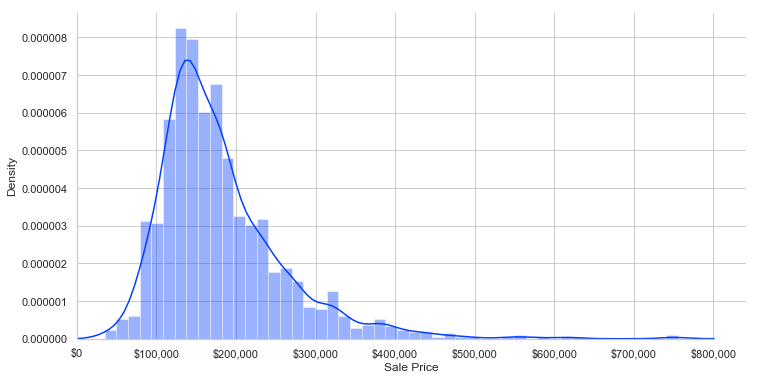

In [6]:
sns.set(style="whitegrid", palette='bright')

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    fig, ax = plt.subplots(figsize=(12,6))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '${:,.0F}'.format(x))) 
    p = sns.distplot(train_df['SalePrice'], kde=True, rug=False, ax=ax)
    ax.set(xlabel='Sale Price', ylabel='Density')
    sns.despine(trim=True)
    p.set(xlim=(0, None), ylim=(0,None))

Positively skewed with a few significant outliers at around $500-800k.

In [7]:
#skewness and kurtosis
print("Skew: {:.2f}".format(train_df['SalePrice'].skew()))
print("Kurtosis: {:.2f}".format(train_df['SalePrice'].kurt()))

Skew: 1.88
Kurtosis: 6.54


# 5. **Analyse of Features - Bivariate analysis**

### 5.1 **Relationship with selected numerical 'space' variables**

* LotFrontage
* LotArea
* MasVnrArea
* BsmtFinSF1
* BsmtFinSF2
* BsmtUnfSF
* TotalBsmtSF
* 1stFlrSF
* 2ndFlrSF
* LowQualFinSF
* GrLivArea
* GarageArea
* WoodDeckSF
* OpenPorchSF
* EnclosedPorch
* 3SsnPorch
* ScreenPorch
* PoolArea

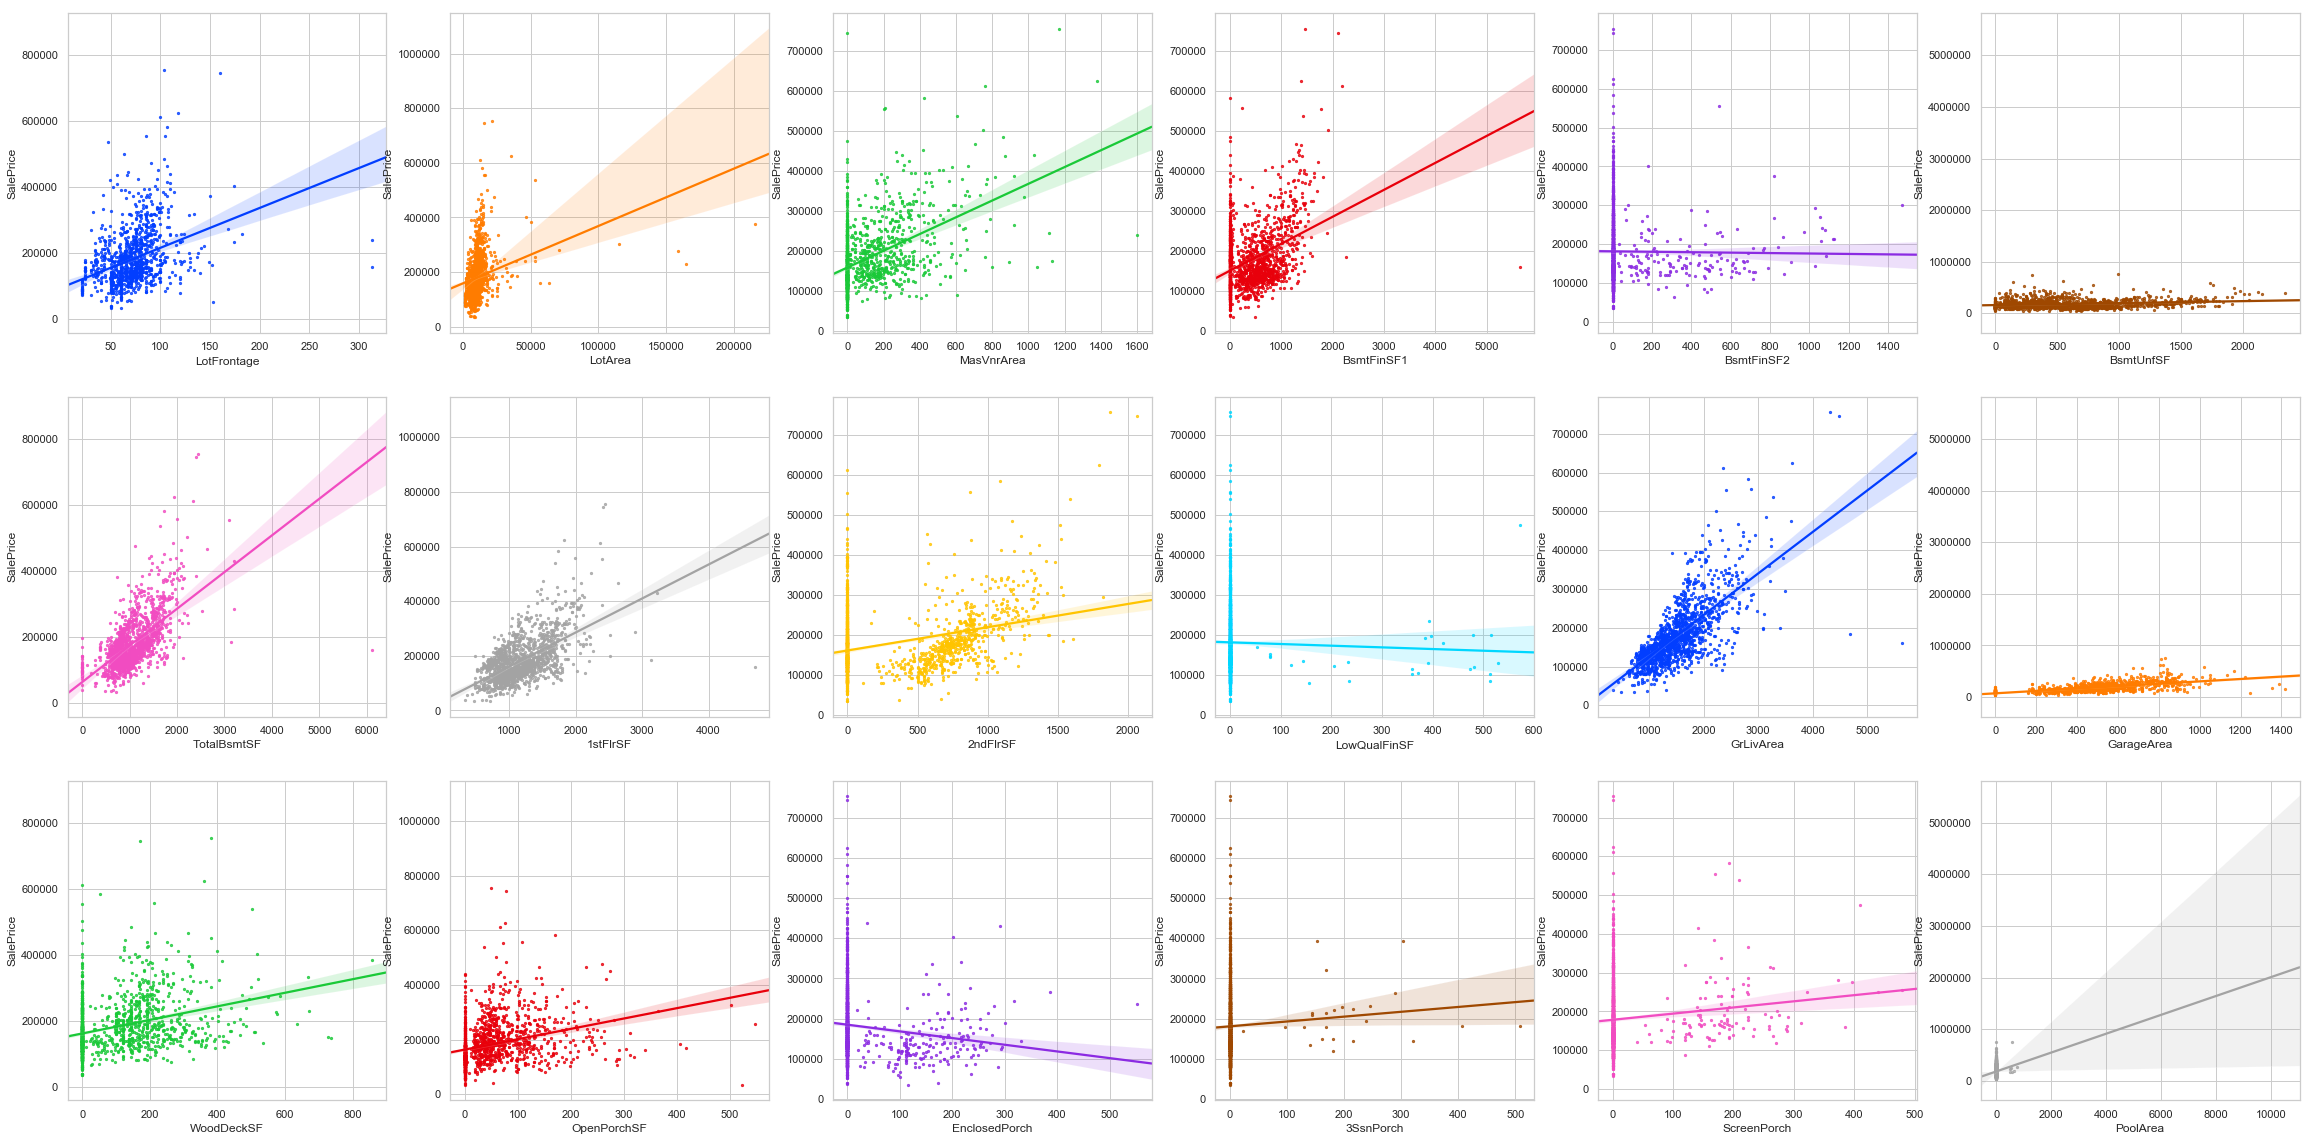

In [8]:
# g = sns.PairGrid(train_df, x_vars=["SalePrice"], y_vars=["LotArea", 'TotalBsmtSF', 'GrLivArea'], height=4, aspect=2)
# grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
fig, axes = plt.subplots(3, 6, figsize=(40, 20), sharey='col')
y = train_df["SalePrice"]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    x = train_df['LotFrontage']
    sns.regplot(x, y, ax=axes[0,0], scatter_kws={"s": 5})
    x = train_df['LotArea']
    sns.regplot(x, y, ax=axes[0,1], scatter_kws={"s": 5})
    x = train_df['MasVnrArea']
    sns.regplot(x, y, ax=axes[0,2], scatter_kws={"s": 5})
    x = train_df['BsmtFinSF1']
    sns.regplot(x, y, ax=axes[0,3], scatter_kws={"s": 5})
    x = train_df['BsmtFinSF2']
    sns.regplot(x, y, ax=axes[0,4], scatter_kws={"s": 5})
    x = train_df['BsmtUnfSF']
    sns.regplot(x, y, ax=axes[0,5], scatter_kws={"s": 5})
    x = train_df['TotalBsmtSF']
    sns.regplot(x, y, ax=axes[1,0], scatter_kws={"s": 5})
    x = train_df['1stFlrSF']
    sns.regplot(x, y, ax=axes[1,1], scatter_kws={"s": 5})
    x = train_df['2ndFlrSF']
    sns.regplot(x, y, ax=axes[1,2], scatter_kws={"s": 5})
    x = train_df['LowQualFinSF']
    sns.regplot(x, y, ax=axes[1,3], scatter_kws={"s": 5})
    x = train_df['GrLivArea']
    sns.regplot(x, y, ax=axes[1,4], scatter_kws={"s": 5})
    x = train_df['GarageArea']
    sns.regplot(x, y, ax=axes[1,5], scatter_kws={"s": 5})
    x = train_df['WoodDeckSF']
    sns.regplot(x, y, ax=axes[2,0], scatter_kws={"s": 5})
    x = train_df['OpenPorchSF']
    sns.regplot(x, y, ax=axes[2,1], scatter_kws={"s": 5})
    x = train_df['EnclosedPorch']
    sns.regplot(x, y, ax=axes[2,2], scatter_kws={"s": 5})
    x = train_df['3SsnPorch']
    sns.regplot(x, y, ax=axes[2,3], scatter_kws={"s": 5})
    x = train_df['ScreenPorch']
    sns.regplot(x, y, ax=axes[2,4], scatter_kws={"s": 5})
    x = train_df['PoolArea']
    sns.regplot(x, y, ax=axes[2,5], scatter_kws={"s": 5})


Looking at the regression plots above there are a few positive linear reltionships of varying stregnths:
* TotalBsmtSF - weak
* 1stFlrFSF - weak
* GrLivARea - slight less weak

### **5.2 Relationship with selected categorical variables**

* MSSubClass
* MSZoning
* Neighborhood
* BldgType
* YearBuilt

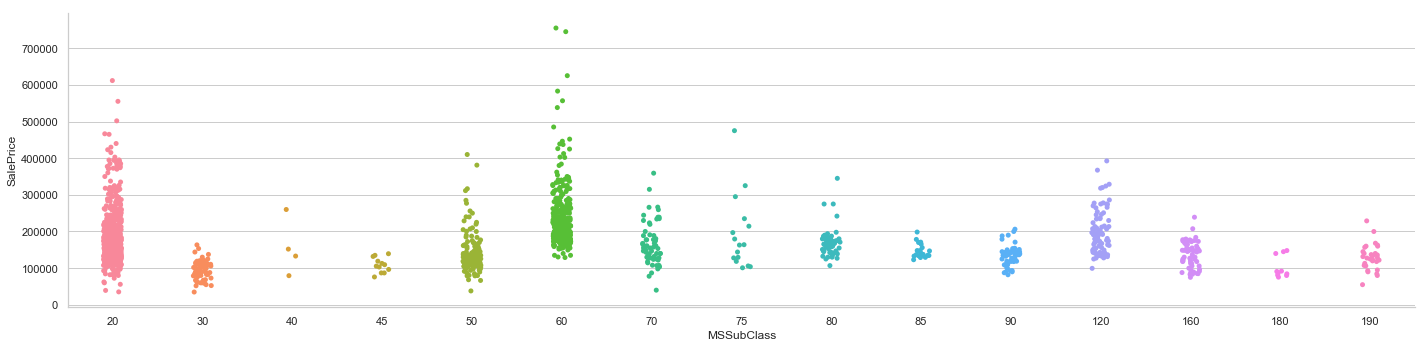

In [9]:
#scatter plot grlivarea/saleprice
var = 'MSSubClass'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
sns.catplot(x=var, y='SalePrice', data=data, height=5, aspect=4)

Some relationship between MSSubClass - notably for values of 20 and 60 reaching to the higher Sales Prices - but not worth including.
  
  
  

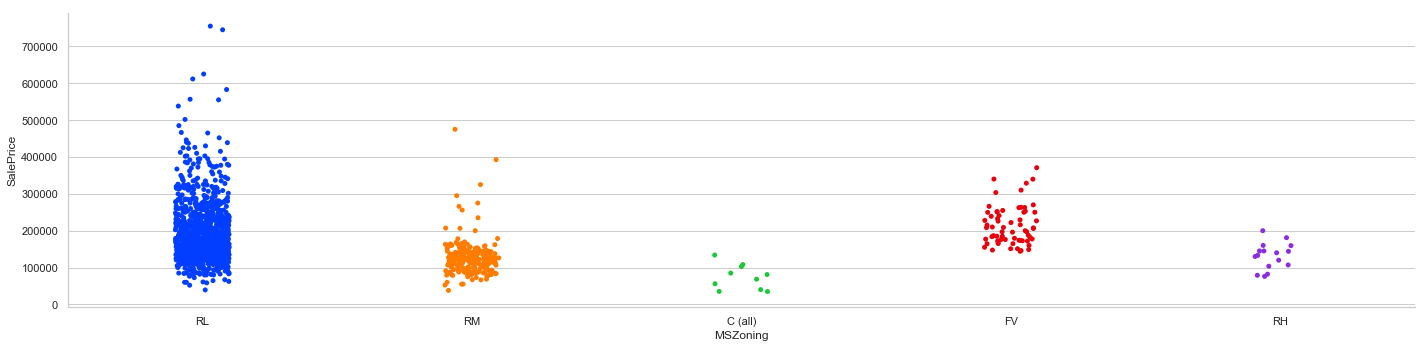

In [10]:
#scatter plot grlivarea/saleprice
var = 'MSZoning'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
sns.catplot(x=var, y='SalePrice', data=data, height=5, aspect=4)

Some indication that RL dives a higher Sales Price (it stands for low density residential) - so understandable.  But it's not differentiating as most houses sold fall into this category.

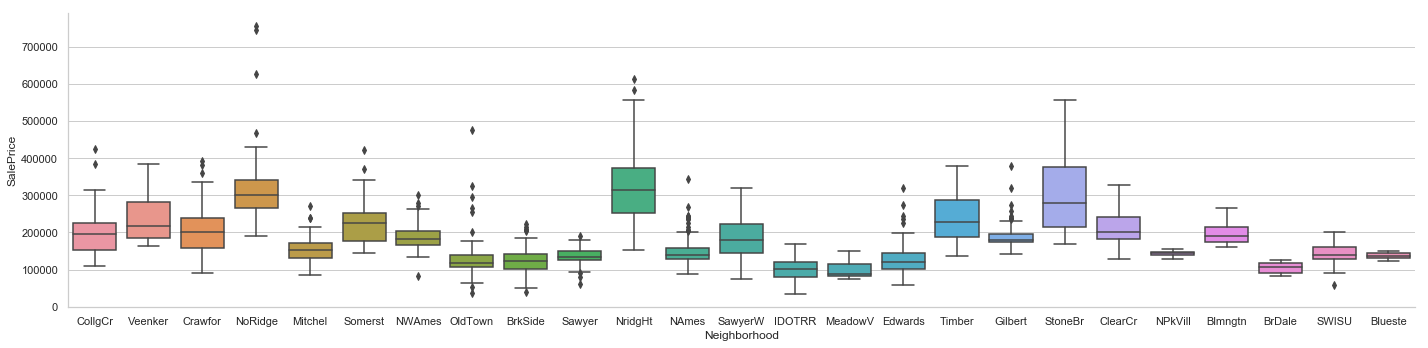

In [11]:
#scatter plot grlivarea/saleprice
var = 'Neighborhood'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
sns.catplot(x=var, y='SalePrice', data=data, height=5, aspect=4, kind='box')

There is no clear patter or relationship.  A couple of Neighborhoods do drive highervalues (NoRidge - Northridge and NridgHt - Northridge Heights) - but the overall distributions by Neighborhood don't add much value to the model.

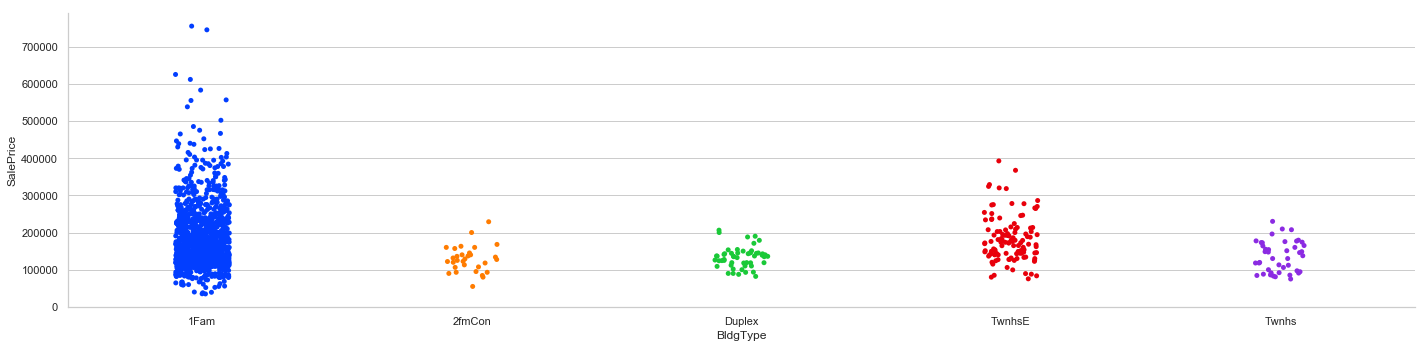

In [12]:
#scatter plot grlivarea/saleprice
var = 'BldgType'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
sns.catplot(x=var, y='SalePrice', data=data, height=5, aspect=4)

Much like MSZoning - BldgType adds little value.

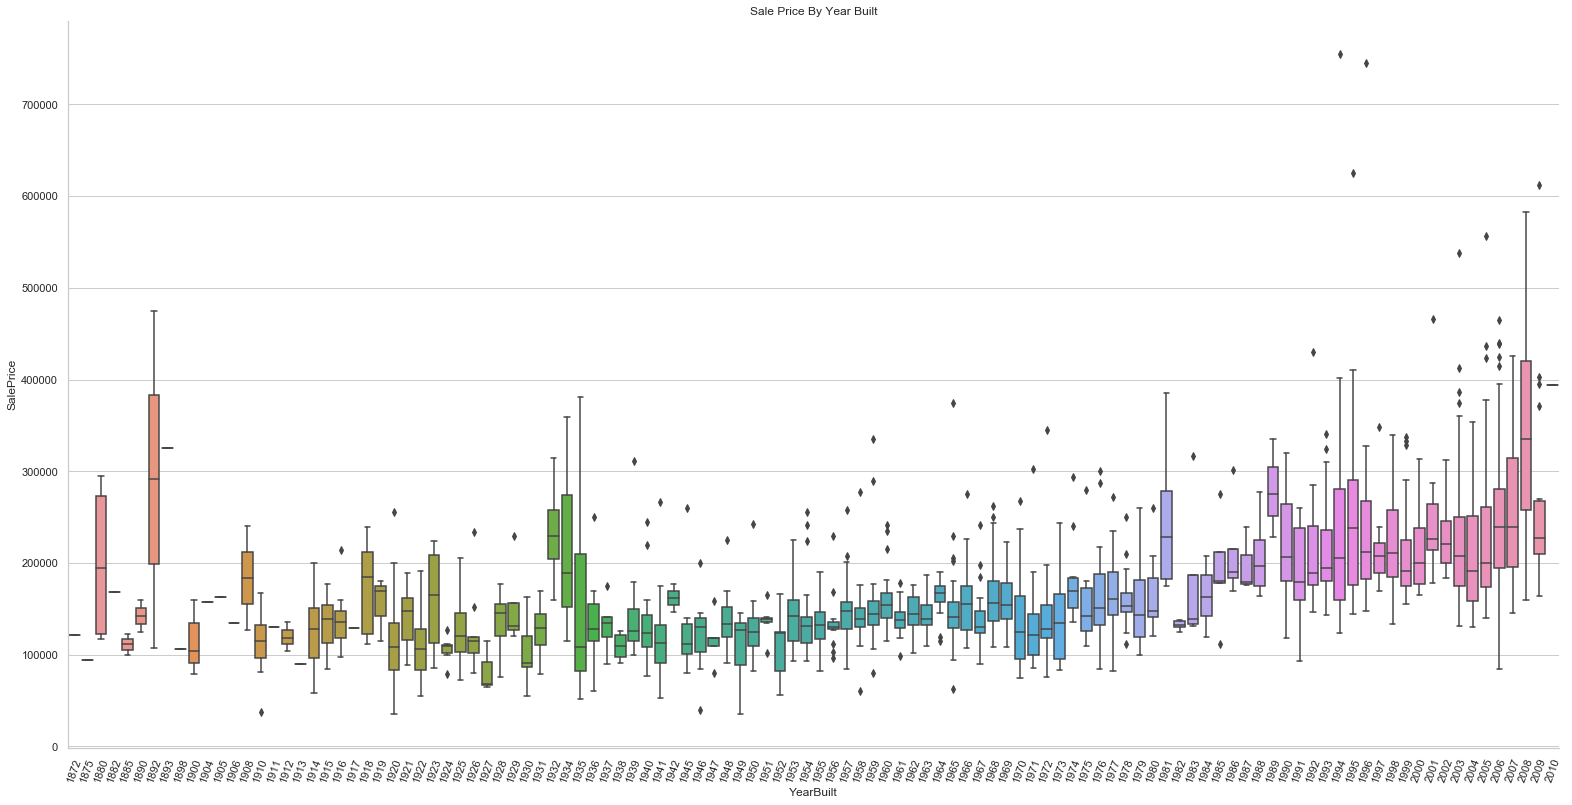

In [13]:
#scatter plot grlivarea/saleprice

# Set variable to investigate
var = 'YearBuilt'

# Create data subset to plot
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)

# fig, ax = plt.subplots(figsize=(30,10))
sns.catplot(x=var, y='SalePrice', data=data, height=11, aspect=2, kind='box')
# sns.boxplot(ax=ax, x=var, y='SalePrice', data=data)
_ = plt.xticks(rotation=70)
_ = plt.title('Sale Price By Year Built')# Set title with matplotlib

The trend is for house prices to up over time, but it's not as strong a relationship as I would have thought.  Notably, prices seem to ramp up around towards the end of the '80's with a huge hike just before the crash around 2008.

# **6. More robust analysis**

* Produce a Heatmap to examine the relative coefficicients between features


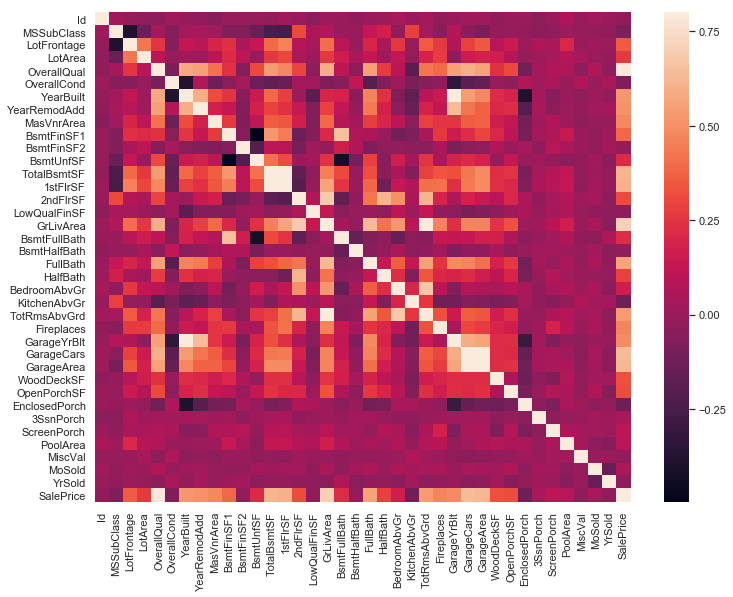

In [14]:
corrmat = train_df.corr()
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.8, square=False);

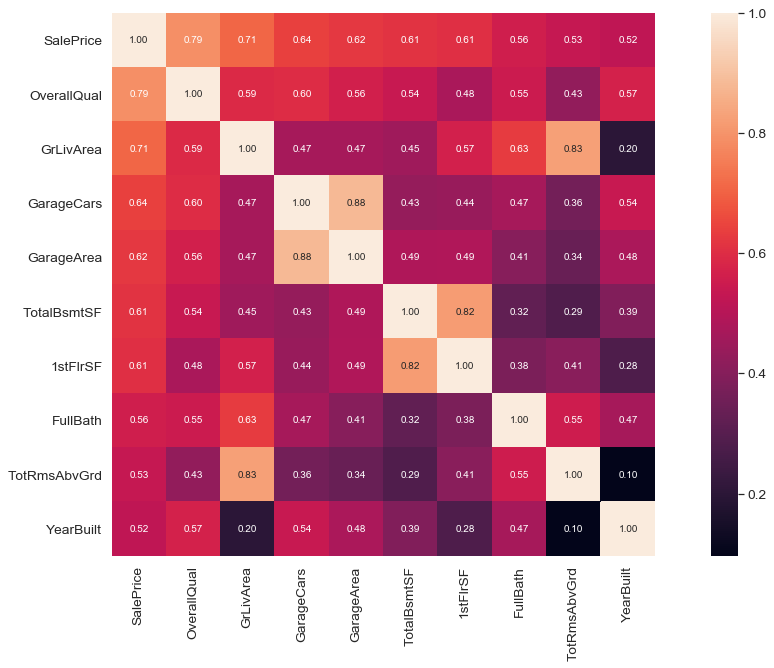

In [17]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(20, 10))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# 7. Missing Data



In [49]:
#missing data
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageQual,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479


### Drop Columns due to missing values

If more than 15% of data is missing then we will remove the feature; so based on the above we'll drop the following features:
* PoolQC
* MiscFeature
* Alley
* Fence
* FirePlaceQu
* LotFrontage

### Drop Columns due to overlap with another feature
Some features have a very similar corrleation and overlap
#### Observations:
* TotalBsmtSF and 1stFlrSF have exactly the same correlation and are very likely to be aligend because the basement size will likely dictate the size of the 1st floor
* All the Garage variables have the same number of missing values (pro

#### Decisions:


# 3. Analyse Data

# Analyse by describing data

### Which features are avalable to us?
There are 79 features (excl. Id and SalePrice)

## **Which features are categorical?**
These values classify the samples into sets of similar samples. Within categorical features are the values nominal, ordinal, ratio, or interval based? Among other things this helps us select the appropriate plots for visualization.

* Nominal: 'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType', 'PavedDrive', 'MiscFeature', 'SaleType', 'SaleCondition'


* Ordinal: 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence'


* Interval - Discreet: 'YearBuilt', 'YearRemodAdd' (=same as YearBuilt if no remodelling), 'YrSold', 'MoSold', 'GarageYrBlt'

## **Which features are numerical?**
These values change from sample to sample. Within numerical features are the values discrete, continuous, or timeseries based? Among other things this helps us select the appropriate plots for visualization.

* Nominal (Discreet): 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars'


* Ratio - Continuous: 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',  'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice'

In [16]:
cols = list(train_df)
print('{0} features:\n{1}\n'.format(len(cols), cols)) # print all column names

81 features:
['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolAr

## **Which are the alphanumeric features?**
LotConfig, BldgType, HouseStyle are all alphanumeric features.  
<br>
## **Which features may contain errors or typos?**
This is hard for such a large dataset with so many features - but there don't appear to be any obvious features which could contain typos such as a Name or a Title feature.  
<br>

In [17]:
# Preview the data
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## **Which features contain blank, missing or null values?**
Columns with null values: 



In [44]:

# msno.bar(train_df)
# msno.bar(test_df)

#missing data
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageQual,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479


## **What is the distribution of numeric features?**
<br>

In [19]:
train_df.describe(exclude=[np.object])

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## **What is the distribution of categorical features?**
<br>

In [20]:
train_df.describe(include=[np.object])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


### **Assumtions based on data analysis**
We arrive at following assumptions based on data analysis done so far. We may validate these assumptions further before taking appropriate actions.

**Correlating**

    1. We want to know how well does each feature correlate with Sale Price. We want to do this early in our project and match these quick
    correlations with modelled correlations later in the project.
    
    
**Completing**

    1. We may want to complete some of the features.


**Correcting**

    1. The following may be dropped based on the number of nulls in the Train dataset - as per the null values analysis - select those whose null value exceeds ~80%
    2. The following may be dropped based on the number of nulls in the Test dataset - as per the null values analysis - select those whose null value exceeds ~80%.
    
    
**Creating**

    1. We may want to create a new feature called:
    Remodelled - to indicate if the property has in fact been remodelled - it's implied if the year remodelled value is different from the year built.
    2. We may want to engineer the ... feature to extract ... as a new feature. - None
    3. We may want to create new feature for ... bands. - None
    4. We may also want to create a ... range feature if it helps our analysis. - None
    
    
**Classifying**

    1. We may also add to our assumptions based on the problem description noted earlier.



## **Analyze by pivoting features**
To confirm some of our observations and assumptions, we can quickly analyze our feature correlations by pivoting features against each other. We can only do so at this stage for features which do not have any empty values. It also makes sense doing so only for features which are categorical, ordinal or discrete
Categorical:
* Nominal (Discreet): 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars'


* Ordinal: 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence'


* Interval - Discreet: 'YearBuilt', 'YearRemodAdd' (=same as YearBuilt if no remodelling), 'YrSold', 'MoSold', 'GarageYrBlt'

In [21]:
def analyse_categoricals(df, cols, df_list):
    for c in cols:
        df = train_df.groupby(c).agg({c: ['count'], 'SalePrice': [np.mean, np.min, np.max]})                         
        df.columns = ["_".join(x) for x in df.columns.ravel()]
        df.reset_index(inplace=True, drop=False)
        df_s = (df.sort_values(by=[c + '_count'], ascending=False))
        print('Categorical Feature: ' + c + '\n===================================')
        width = 20
        print('{: <{width}}{: <{width}}{:{width}}{:{width}}{:{width}}'.
              format(c, 'Count', 'Sales_Price_Mean', 'Sales_Price_Min', 'Sales_Price_Max', width=width))
        for index, row in df_s.iterrows():
            if row.iloc[1] != 0:
                print('{: <{width}}{: <{width}.0f}{: <{width}.2F}{: <{width}.2F}{: <{width}.2F}'.
                      format(row.iloc[0], row.iloc[1], row.iloc[2], row.iloc[3], row.iloc[4], width=width))
        print()
        df_list.append(df_s)
    return df_list

df_list = []
cols = ['Utilities', 'MasVnrType', 'MSZoning', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence','YearBuilt',
        'YearRemodAdd', 'YrSold', 'MoSold', 'GarageYrBlt']
dfs = analyse_categoricals(train_df, cols, df_list)

Categorical Feature: Utilities
Utilities           Count               Sales_Price_Mean    Sales_Price_Min     Sales_Price_Max     
AllPub              1459                180950.96           34900.00            755000.00           
NoSeWa              1                   137500.00           137500.00           137500.00           

Categorical Feature: MasVnrType
MasVnrType          Count               Sales_Price_Mean    Sales_Price_Min     Sales_Price_Max     
None                864                 156221.89           34900.00            745000.00           
BrkFace             445                 204691.87           75000.00            755000.00           
Stone               128                 265583.62           119000.00           611657.00           
BrkCmn              15                  146318.07           89471.00            277000.00           

Categorical Feature: MSZoning
MSZoning            Count               Sales_Price_Mean    Sales_Price_Min     Sales_Price_Max  

Categorical Feature: YrSold
YrSold              Count               Sales_Price_Mean    Sales_Price_Min     Sales_Price_Max     
2009.0              338                 179432.10           34900.00            582933.00           
2007.0              329                 186063.15           39300.00            755000.00           
2006.0              314                 182549.46           35311.00            625000.00           
2008.0              304                 177360.84           40000.00            446261.00           
2010.0              175                 177393.67           55000.00            611657.00           

Categorical Feature: MoSold
MoSold              Count               Sales_Price_Mean    Sales_Price_Min     Sales_Price_Max     
6.0                 253                 177395.74           55993.00            538000.00           
7.0                 234                 186331.19           40000.00            745000.00           
5.0                 204           

## **Analyse by Visualising Data **

To confirm some of our observations and assumptions, we can quickly analyze our feature correlations by pivoting features against each other. We can only do so at this stage for features which do not have any empty values. It also makes sense doing so only for features which are categorical, ordinal or discrete (SibSp, Parch) type.
  

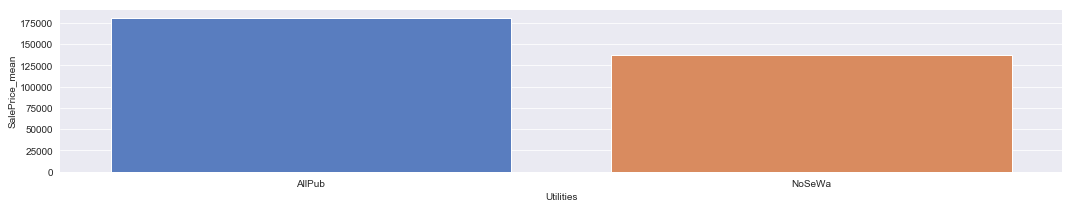

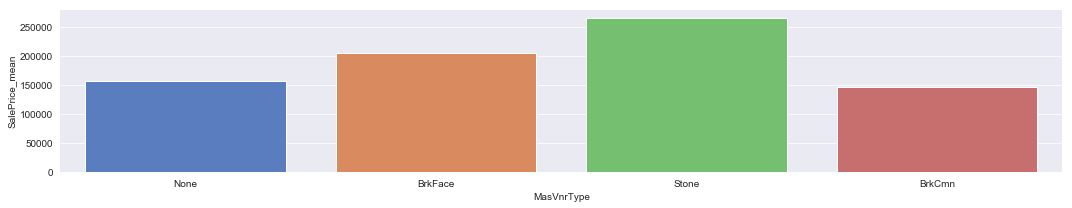

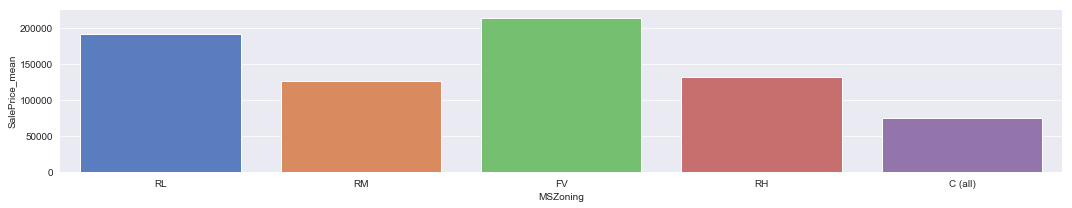

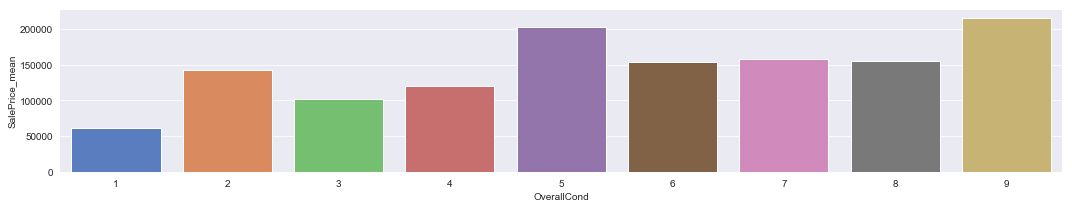

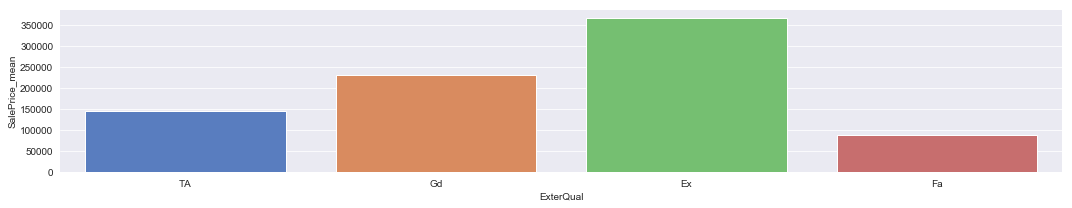

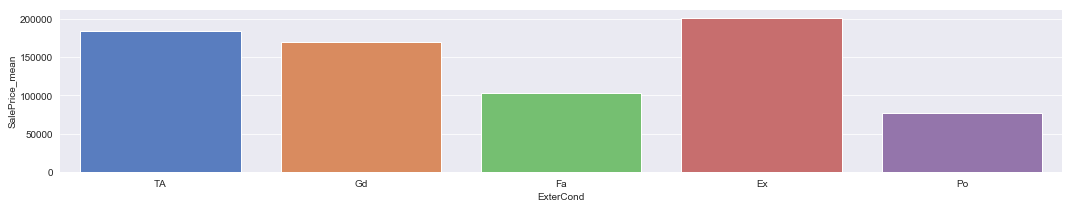

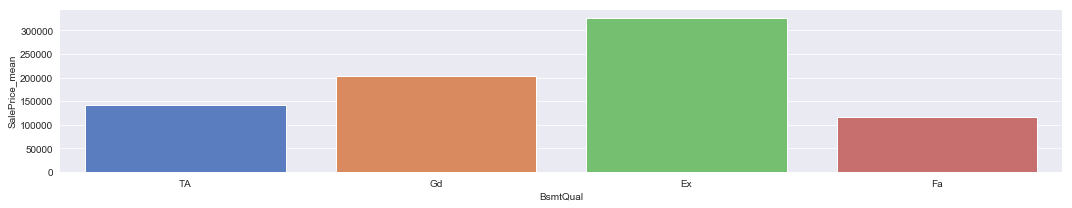

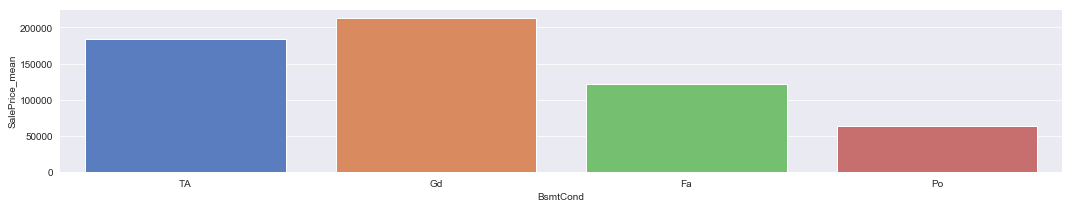

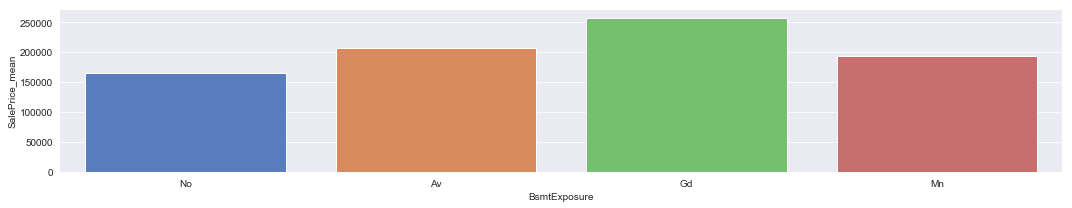

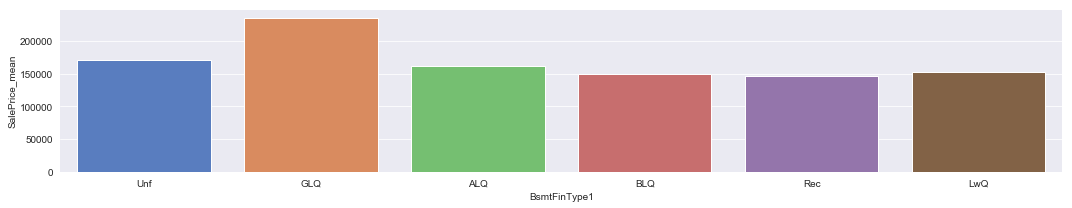

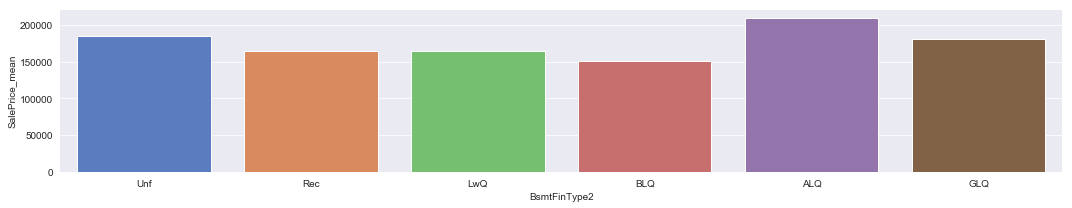

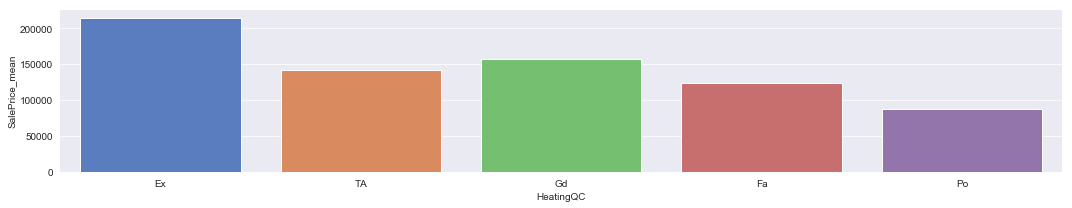

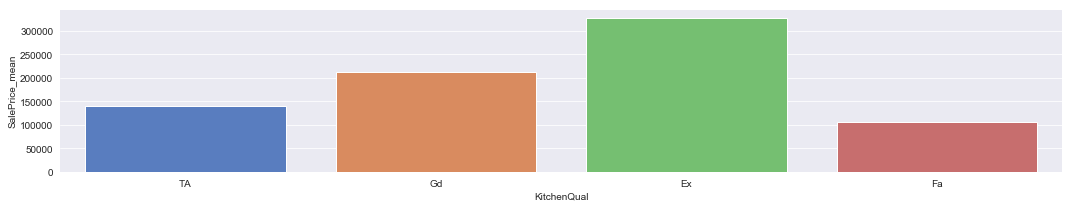

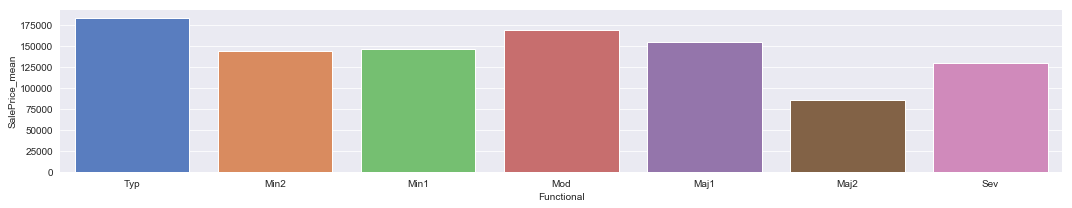

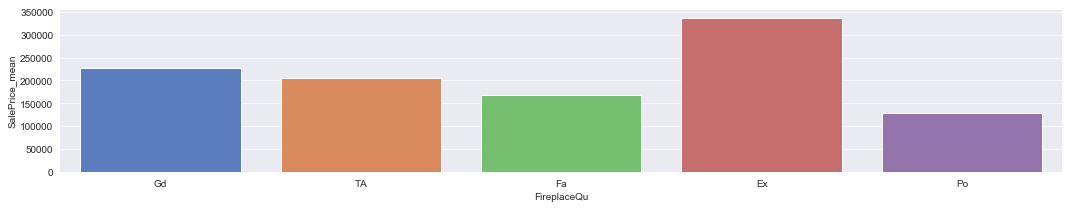

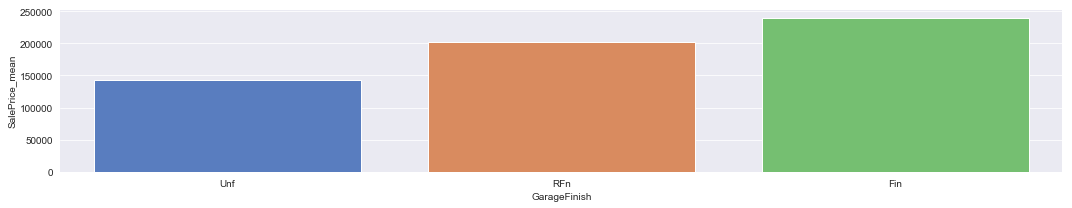

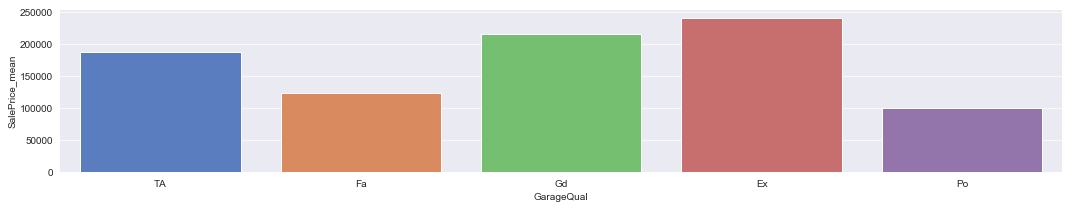

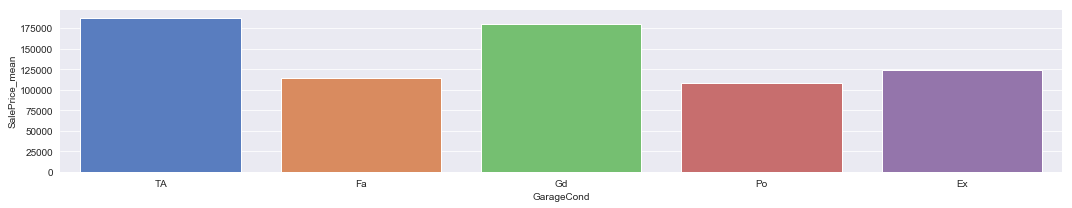

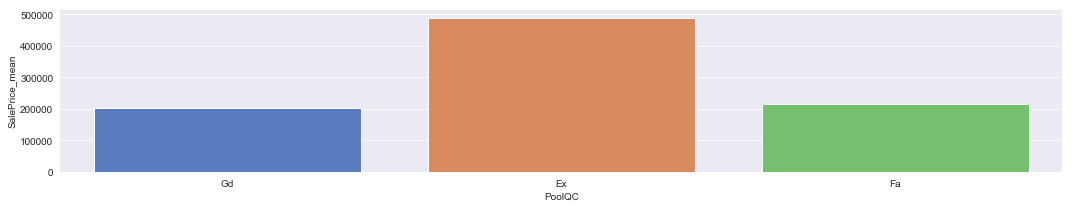

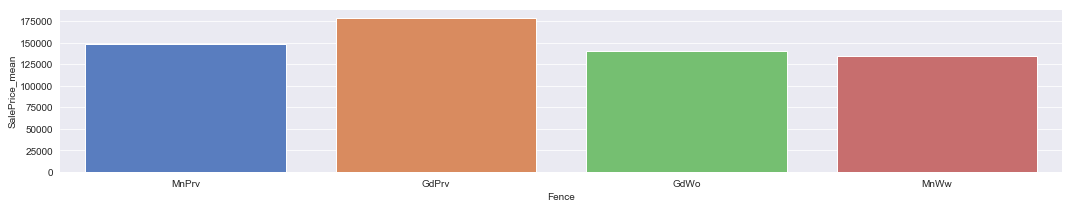

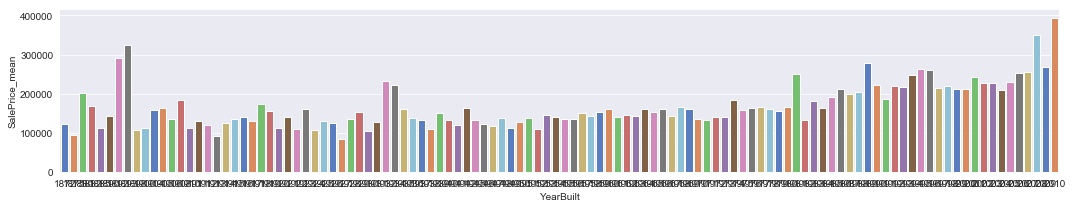

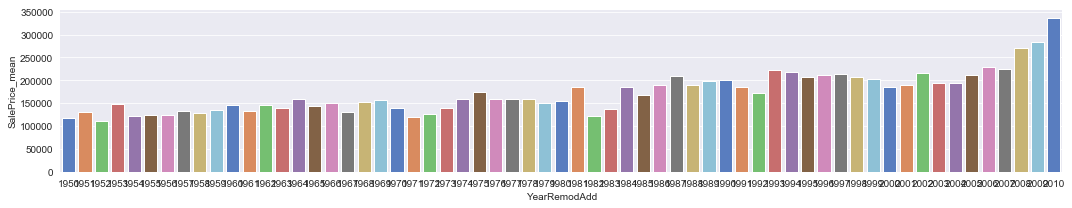

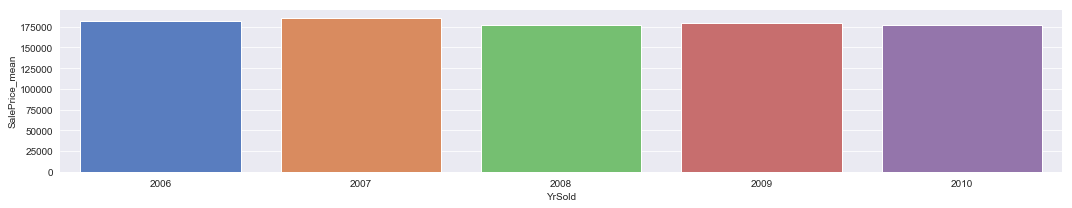

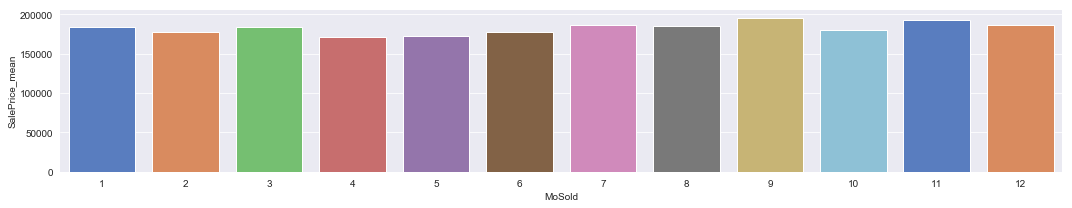

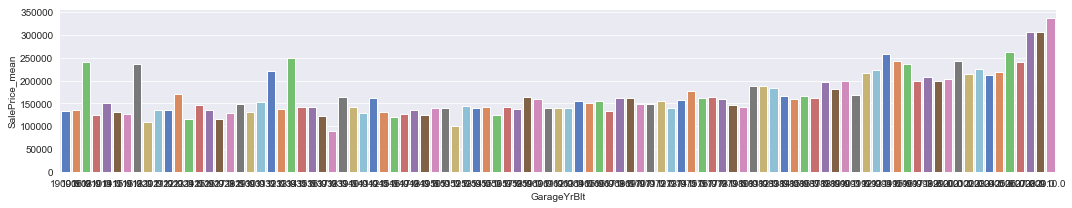

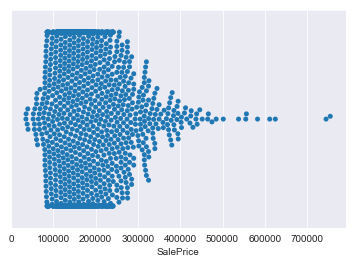

In [22]:
def draw_cat_plot(df, x, y, kind=None, palette=None):
    p = sns.catplot(x=x, y=y, data=df, kind=kind, height=3, aspect=5, palette=palette)
    p.despine(left=True)

for df in dfs:
    draw_cat_plot(df, df.columns[0], 'SalePrice_mean', 'bar', 'muted')
    plt.show()
ax = sns.swarmplot(x=train_df["SalePrice"])

# **4. Wrangle data**
We have collected several assumptions and decisions regarding our datasets and solution requirements. So far we did not have to change a single feature or value to arrive at these. Let us now execute our decisions and assumptions for correcting, creating, and completing goals.

Correcting by dropping features
This is a good starting goal to execute. By dropping features we are dealing with fewer data points. Speeds up our notebook and eases the analysis.

Based on our assumptions and decisions we want to drop



In [23]:
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

def drop_cols(df, cols):
    df.drop(cols, axis=1, inplace=True)
# test_df = test_df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1)

cols = ['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence']
drop_cols(train_df, cols)
cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence']
drop_cols(test_df, cols)

combine = [train_df, test_df]
print("After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)
train_df.head()

Before (1460, 81) (1459, 80) (1460, 81) (1459, 80)
After (1460, 76) (1459, 76) (1460, 76) (1459, 76)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


### **Creating new feature extracting from existing**

**Observations**

Year Sold and Month Sold could possible be combine - but there is little evidence to suggest sales are significantly impacted by month of year.

YearRemodAdd is equal to YearBuilt if no remodelling has taken place but different if it has.  It's resonable t oassume that a redmodelled property would fetch a higher asking price so creating a new field to indicate if the property has been remodelled may be worthwhile. 

**Decision**

We decide to create a new feature called Remodelled.

In [24]:
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

for df in combine:
    df['Remodelled'] = df.apply(lambda row: 1 if row['YearBuilt'] != row['YearRemodAdd'] else 0, axis=1)
    print()
    width = 20
    print('{: <{width}}{: <{width}}{: <{width}}'.format('YearBuilt', 'YearRemodAdd', 'Remodelled', width=width))
    for x in (range(5)):
        print('{: <{width}}{: <{width}}{: <{width}}'.format(train_df['YearBuilt'][x], train_df['YearRemodAdd'][x], train_df['Remodelled'][x], 
                                                            width=width))

combine = [train_df, test_df]
print("After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)
train_df.head()

Before (1460, 76) (1459, 76) (1460, 76) (1459, 76)

YearBuilt           YearRemodAdd        Remodelled          
2003                2003                0                   
1976                1976                0                   
2001                2002                1                   
1915                1970                1                   
2000                2000                0                   

YearBuilt           YearRemodAdd        Remodelled          
2003                2003                0                   
1976                1976                0                   
2001                2002                1                   
1915                1970                1                   
2000                2000                0                   
After (1460, 77) (1459, 77) (1460, 77) (1459, 77)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Remodelled
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,0
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,0
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,1
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000,1
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,0


### **Convert categorical feature to ordinal**

In [25]:
# Set Category features to correct dtype and fill NaaN's with the median value
cols = ['YearBuilt', 'YearRemodAdd', 'MSSubClass', 'Street','LotShape','LandContour','LotConfig','LandSlope','Neighborhood','Condition1','Condition2',
        'BldgType','HouseStyle','RoofStyle', 'RoofMatl','Exterior1st','Exterior2nd','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond',
        'BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu',
        'GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','SaleType','SaleCondition', 'GarageYrBlt', 'MasVnrType', 'MSZoning',
        'Utilities']

def parse_categorical(df):
    for col in cols:
        df[col] = df[col].astype('category')
        df[col] = df[col].cat.codes
        apositive = list(filter(lambda x:x>0, df[col]))  # We use the median value to populate any NaaN's - ignpre any -ve (NaaN's)
        if sum(apositive) == 0:  # But if there is only one category then the sum will be 0 (1 cat starting at 0)-so the median calc issues a warning
            df.loc[df[col] == -1, col] = 0  # Any NaaN's will be set to -1 - so we set them to 0, the only category that exists for this feature
        else:
            df.loc[df[col] == -1, col] = np.median(apositive)
        
for df in combine:
    parse_categorical(df)

combine = [train_df, test_df]
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Remodelled
0,5.0,3.0,65.0,8450,1.0,3.0,3.0,0.0,4.0,0.0,5.0,2.0,2.0,0.0,5.0,7,5,104.0,53.0,1.0,1.0,12.0,13.0,1.0,196.0,2.0,4.0,2.0,2.0,3.0,3.0,2.0,706,5.0,0,150,856,1.0,0.0,1.0,4.0,856,854,0,1710,1,0,2,1,3,1,2.0,8,6.0,0,2.0,1.0,89.0,1.0,2,548,4.0,4.0,2.0,0,61,0,0,0,0,0,2,2008,8.0,4.0,208500,0
1,0.0,3.0,80.0,9600,1.0,3.0,3.0,0.0,2.0,0.0,24.0,1.0,2.0,0.0,2.0,6,8,77.0,26.0,1.0,1.0,8.0,8.0,2.0,0.0,3.0,4.0,1.0,2.0,3.0,1.0,0.0,978,5.0,0,284,1262,1.0,0.0,1.0,4.0,1262,0,0,1262,0,1,2,0,3,1,3.0,6,6.0,1,4.0,1.0,62.0,1.0,2,460,4.0,4.0,2.0,298,0,0,0,0,0,0,5,2007,8.0,4.0,181500,0
2,5.0,3.0,68.0,11250,1.0,0.0,3.0,0.0,4.0,0.0,5.0,2.0,2.0,0.0,5.0,7,5,102.0,52.0,1.0,1.0,12.0,13.0,1.0,162.0,2.0,4.0,2.0,2.0,3.0,2.0,2.0,486,5.0,0,434,920,1.0,0.0,1.0,4.0,920,866,0,1786,1,0,2,1,3,1,2.0,6,6.0,1,4.0,1.0,87.0,1.0,2,608,4.0,4.0,2.0,0,42,0,0,0,0,0,9,2008,8.0,4.0,223500,1
3,6.0,3.0,60.0,9550,1.0,0.0,3.0,0.0,0.0,0.0,6.0,2.0,2.0,0.0,5.0,7,5,19.0,20.0,1.0,1.0,13.0,15.0,2.0,0.0,3.0,4.0,0.0,3.0,1.0,3.0,0.0,216,5.0,0,540,756,1.0,2.0,1.0,4.0,961,756,0,1717,1,0,1,0,3,1,2.0,7,6.0,1,2.0,5.0,84.0,2.0,3,642,4.0,4.0,2.0,0,35,272,0,0,0,0,2,2006,8.0,0.0,140000,1
4,5.0,3.0,84.0,14260,1.0,0.0,3.0,0.0,2.0,0.0,15.0,2.0,2.0,0.0,5.0,8,5,101.0,50.0,1.0,1.0,12.0,13.0,1.0,350.0,2.0,4.0,2.0,2.0,3.0,0.0,2.0,655,5.0,0,490,1145,1.0,0.0,1.0,4.0,1145,1053,0,2198,1,0,2,1,4,1,2.0,9,6.0,1,4.0,1.0,86.0,1.0,3,836,4.0,4.0,2.0,192,84,0,0,0,0,0,12,2008,8.0,4.0,250000,0


### **Completing a numerical continuous feature**

Now we should start estimating and completing features with missing or null values.

We can consider three methods to complete a numerical continuous feature.

1. A simple way is to generate random numbers between mean and standard deviation.


2. More accurate way of guessing missing values is to use other correlated features. In our case we note correlation among Age, Gender, and Pclass. Guess Age values using median values for Age across sets of Pclass and Gender feature combinations. So, median Age for Pclass=1 and Gender=0, Pclass=1 and Gender=1, and so on...


3. Combine methods 1 and 2. So instead of guessing age values based on median, use random numbers between mean and standard deviation, based on sets of Pclass and Gender combinations.


Method 1 and 3 will introduce random noise into our models. The results from multiple executions might vary. We will use method 2.

In [26]:
def parse_numeric(df, cols):
    for col in cols:
        df[col] = df[col].fillna(df[col].median())

cols = ['SalePrice', 'LotFrontage','MasVnrArea','BsmtHalfBath','BsmtFullBath','GarageArea','GarageCars','TotalBsmtSF','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1']
parse_numeric(train_df, cols)
cols = ['LotFrontage','MasVnrArea','BsmtHalfBath','BsmtFullBath','GarageArea','GarageCars','TotalBsmtSF','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1']
parse_numeric(test_df, cols)

check_cols(train_df,'Train')
check_cols(test_df,'Test')
train_df.info()
combine = [train_df, test_df]
train_df.head()
train_df['SalePrice'].value_counts()


Train Column Analysis
-1 columns in the Train dataset with null values:

Empty DataFrame
Columns: [Col, Num_Nulls, Num_Nulls_Perc]
Index: []


0 columns in the Train dataset which are all spaces:

10 columns in the Train dataset which are not all spaces.


Test Column Analysis
-1 columns in the Test dataset with null values:

Empty DataFrame
Columns: [Col, Num_Nulls, Num_Nulls_Perc]
Index: []


0 columns in the Test dataset which are all spaces:

10 columns in the Test dataset which are not all spaces.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 77 columns):
MSSubClass       1460 non-null float64
MSZoning         1460 non-null float64
LotFrontage      1460 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null float64
LotShape         1460 non-null float64
LandContour      1460 non-null float64
Utilities        1460 non-null float64
LotConfig        1460 non-null float64
LandSlope        1460 non-null flo

140000    20
135000    17
145000    14
155000    14
190000    13
110000    13
160000    12
115000    12
139000    11
130000    11
125000    10
143000    10
185000    10
180000    10
144000    10
175000     9
147000     9
100000     9
127000     9
165000     8
176000     8
170000     8
129000     8
230000     8
250000     8
200000     8
141000     8
215000     8
148000     7
173000     7
119000     7
128000     7
178000     7
120000     7
181000     7
112000     7
235000     7
174000     7
189000     6
239000     6
152000     6
187500     6
157000     6
240000     6
205000     6
132000     6
113000     6
127500     6
118000     6
108000     6
260000     6
158000     6
225000     6
137500     6
132500     6
133000     6
124000     6
137000     5
172500     5
207500     5
275000     5
105000     5
136500     5
177000     5
290000     5
179900     5
192000     5
214000     5
154000     5
220000     5
210000     5
151000     5
171000     5
184000     4
280000     4
128500     4
315000     4

### **Normalizing numerical continuous features**

Now we should consider normalizing continuous numerical feature.

In [27]:
def normalize(df, cols):
    for col in cols:
        series_mean = df[col].mean()
        series_std = df[col].std()
        df[col] = (df[col] - series_mean) / series_std

cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 'LowQualFinSF', 
        'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch']
normalize(train_df, cols)

cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 'LowQualFinSF', 
        'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch']
normalize(test_df, cols)
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

train_df.info()

combine = [train_df, test_df]
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 77 columns):
MSSubClass       1460 non-null float64
MSZoning         1460 non-null float64
LotFrontage      1460 non-null float64
LotArea          1460 non-null float64
Street           1460 non-null float64
LotShape         1460 non-null float64
LandContour      1460 non-null float64
Utilities        1460 non-null float64
LotConfig        1460 non-null float64
LandSlope        1460 non-null float64
Neighborhood     1460 non-null float64
Condition1       1460 non-null float64
Condition2       1460 non-null float64
BldgType         1460 non-null float64
HouseStyle       1460 non-null float64
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null float64
YearRemodAdd     1460 non-null float64
RoofStyle        1460 non-null float64
RoofMatl         1460 non-null float64
Exterior1st      1460 non-null float64
Exterior2nd      1460 non-null float64


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Remodelled
0,5.0,3.0,-0.220799,-0.207071,1.0,3.0,3.0,0.0,4.0,0.0,5.0,2.0,2.0,0.0,5.0,7,5,104.0,53.0,1.0,1.0,12.0,13.0,1.0,0.513928,2.0,4.0,2.0,2.0,3.0,3.0,2.0,0.575228,5.0,-0.288554,-0.944267,-0.459145,1.0,0.0,1.0,4.0,-0.793162,854,-0.120201,0.370207,1,0,2,1,3,1,2.0,8,6.0,0,2.0,1.0,89.0,1.0,2,0.350880,4.0,4.0,2.0,-0.751918,0.216429,-0.359202,0,0,0,0,2,2008,8.0,4.0,12.247699,0
1,0.0,3.0,0.460162,-0.091855,1.0,3.0,3.0,0.0,2.0,0.0,24.0,1.0,2.0,0.0,2.0,6,8,77.0,26.0,1.0,1.0,8.0,8.0,2.0,-0.570555,3.0,4.0,1.0,2.0,3.0,1.0,0.0,1.171591,5.0,-0.288554,-0.641008,0.466305,1.0,0.0,1.0,4.0,0.257052,0,-0.120201,-0.482347,0,1,2,0,3,1,3.0,6,6.0,1,4.0,1.0,62.0,1.0,2,-0.060710,4.0,4.0,2.0,1.625638,-0.704242,-0.359202,0,0,0,0,5,2007,8.0,4.0,12.109016,0
2,5.0,3.0,-0.084607,0.073455,1.0,0.0,3.0,0.0,4.0,0.0,5.0,2.0,2.0,0.0,5.0,7,5,102.0,52.0,1.0,1.0,12.0,13.0,1.0,0.325803,2.0,4.0,2.0,2.0,3.0,2.0,2.0,0.092875,5.0,-0.288554,-0.301540,-0.313261,1.0,0.0,1.0,4.0,-0.627611,866,-0.120201,0.514836,1,0,2,1,3,1,2.0,6,6.0,1,4.0,1.0,87.0,1.0,2,0.631510,4.0,4.0,2.0,-0.751918,-0.070337,-0.359202,0,0,0,0,9,2008,8.0,4.0,12.317171,1
3,6.0,3.0,-0.447787,-0.096864,1.0,0.0,3.0,0.0,0.0,0.0,6.0,2.0,2.0,0.0,5.0,7,5,19.0,20.0,1.0,1.0,13.0,15.0,2.0,-0.570555,3.0,4.0,0.0,3.0,1.0,3.0,0.0,-0.499103,5.0,-0.288554,-0.061648,-0.687089,1.0,2.0,1.0,4.0,-0.521555,756,-0.120201,0.383528,1,0,1,0,3,1,2.0,7,6.0,1,2.0,5.0,84.0,2.0,3,0.790533,4.0,4.0,2.0,-0.751918,-0.175988,4.091122,0,0,0,0,2,2006,8.0,0.0,11.849405,1
4,5.0,3.0,0.641752,0.375020,1.0,0.0,3.0,0.0,2.0,0.0,15.0,2.0,2.0,0.0,5.0,8,5,101.0,50.0,1.0,1.0,12.0,13.0,1.0,1.366021,2.0,4.0,2.0,2.0,3.0,0.0,2.0,0.463410,5.0,-0.288554,-0.174805,0.199611,1.0,0.0,1.0,4.0,-0.045596,1053,-0.120201,1.298881,1,0,2,1,4,1,2.0,9,6.0,1,4.0,1.0,86.0,1.0,3,1.697903,4.0,4.0,2.0,0.779930,0.563567,-0.359202,0,0,0,0,12,2008,8.0,4.0,12.429220,0


# **Model, predict and solve**

Now we are ready to train a model and predict the required solution. There are 60+ predictive modelling algorithms to choose from. We must understand the type of problem and solution requirement to narrow down to a select few models which we can evaluate. Our problem is a regression problem. We want to identify relationship between output (SalePrice or not) with other variables or features (MSSubClass, LotArea etc...). We are also perfoming a category of machine learning which is called supervised learning as we are training our model with a given dataset. With these two criteria - Supervised Learning plus Regression, we can narrow down our choice of models to a few. These include:

* Logistic Regression
* KNN or k-Nearest Neighbors
* Support Vector Machines
* Naive Bayes classifier
* Decision Tree
* Random Forrest
* Perceptron
* Artificial neural network
* RVM or Relevance Vector Machine

In [28]:

X_train = train_df.drop('SalePrice', axis=1)

Y_train = train_df['SalePrice']
X_test  = test_df.drop('Id', axis=1).copy()
# X_test = test_df
X_train.shape, Y_train.shape, X_test.shape
train_df['SalePrice']
# train_df = train_df.reset_index()
# test_df = test_df.reset_index()

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
5       11.870607
6       12.634606
7       12.206078
8       11.774528
9       11.678448
10      11.771444
11      12.751303
12      11.877576
13      12.540761
14      11.964007
15      11.790565
16      11.911708
17      11.407576
18      11.976666
19      11.842236
20      12.692506
21      11.845110
22      12.345839
23      11.774528
24      11.944714
25      12.454108
26      11.811555
27      12.631344
28      12.242891
29      11.134604
30      10.596660
31      11.914055
32      12.100162
33      12.016733
34      12.533580
35      12.641100
36      11.884496
37      11.938200
38      11.599112
39      11.314487
40      11.982935
41      12.043560
42      11.877576
43      11.777219
44      11.856522
45      12.675767
46      12.387089
47      12.428019
48      11.635152
49      11.751950
50      12.083911
51      11.648339
52      11.608245
53      12.861001
54      11.775297
55      12

### **Logistic Regression**

In [29]:

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

ValueError: Unknown label type: 'continuous'

We can use Logistic Regression to validate our assumptions and decisions for feature creating and completing goals. This can be done by calculating the coefficient of the features in the decision function.

Positive coefficients increase the log-odds of the response (and thus increase the probability), and negative coefficients decrease the log-odds of the response (and thus decrease the probability).

In [ ]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])
coeff_df.sort_values(by='Correlation', ascending=False, inplace=True)

width=20
print('{: <{width}} {: >{width}}\n{: <{width}} {: >{width}}'.format('Feature', 'Correlation', '=======','===========', width=width))
for i in range(coeff_df.shape[0]):
    print('{: <{width}} {: >{width}.5F}'.format(coeff_df['Feature'].iloc[i], coeff_df['Correlation'].iloc[i], width=width))

### **Support Vector Machines**

Next we model using Support Vector Machines which are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training samples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new test samples to one category or the other, making it a non-probabilistic binary linear classifier. Reference Wikipedia.

Note that the model generates a confidence score which is lower than Logistics Regression model.

In [ ]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

### **KNN or k-Nearest Neighbors**

In pattern recognition, the k-Nearest Neighbors algorithm (or k-NN for short) is a non-parametric method used for classification and regression. A sample is classified by a majority vote of its neighbors, with the sample being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor. Reference Wikipedia.

KNN confidence score is lower than both Logistics Regression and the SVM.

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

### **Naive Bayes classifiers**

In machine learning, naive Bayes classifiers are a family of simple probabilistic classifiers based on applying Bayes' theorem with strong (naive) independence assumptions between the features. Naive Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features) in a learning problem. Reference Wikipedia.

The model generated confidence score is higher than KNN but lower than SVM and Logistical Regression.

In [ ]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

### **Perception**

The perceptron is an algorithm for supervised learning of binary classifiers (functions that can decide whether an input, represented by a vector of numbers, belongs to some specific class or not). It is a type of linear classifier, i.e. a classification algorithm that makes its predictions based on a linear predictor function combining a set of weights with the feature vector. The algorithm allows for online learning, in that it processes elements in the training set one at a time. Reference Wikipedia.

In [ ]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

### **Linear SVC**

In [ ]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

### **Stochastic Gradient Descent**

In [ ]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

### **Decision Tree**

This model uses a decision tree as a predictive model which maps features (tree branches) to conclusions about the target value (tree leaves). Tree models where the target variable can take a finite set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees. Reference Wikipedia.

The model confidence score is ...

In [ ]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

### **Random Forests**

The next model Random Forests is one of the most popular. Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees (n_estimators=100) at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Reference Wikipedia.

The model confidence score is the highest among models evaluated so far. We decide to use this model's output (Y_pred) for creating our competition submission of results.

In [ ]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

### **Model evaluation**

We can now rank our evaluation of all the models to choose the best one for our problem. While both Decision Tree and Random Forest score the same, we choose to use Random Forest as they correct for decision trees' habit of overfitting to their training set.

In [ ]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

### **Create submission file**

In [ ]:
submission = pd.DataFrame({
        'Id': test_df['Id'],
        'SalePrice': Y_pred
    })

submission.to_csv('C:/Users/770000411/OneDrive - Genpact/02 - Personal/Jupyter Projects/Predict House Prices/submission.csv', index=False)